# Small Object Detection on Traffic Light Dataset using RT-DETR

### Traffic Light Dataset Overview:

The **Small Traffic Light dataset** is an open-source computer vision dataset created by SovitOpenCVUniversity for developing and evaluating traffic light detection models. It consists of 1,222 annotated images focused on capturing various traffic light instances in real-world scenes, making it suitable for training and benchmarking object detection algorithms, especially those that must recognize small, context-dependent signals in complex environments.

* **Number of Training Images**: 855
  
* **Number of Validation Images**: 367

* **Image Resolution**: 1920 x 1080

* **Traffic Light Classes**: ['Green', 'off', 'red', 'wait_on', 'yellow']

* **Image Characteristics**:
    * Collected from various real-world scenes such as urban streets and road intersections.
    * Captures traffic lights at different scales, poses, lighting conditions, and backgrounds.
    * Challenging for small object detection due to varying distances and sizes. 
  
* [Traffic Dataset Download Link](https://www.dropbox.com/scl/fi/v60994ucoillzfzcwe1kl/Small-Traffic-Light.v1i.yolov11.zip?rlkey=b28kal2b8egup5u73vigh953f&st=kqiijqnv&dl=1)

**Sample Images**:

![Problem Statement](images/problem-statement.png)

### RT-DETR Model Architecture Overview:

**RT-DETR (Real-Time DEtection TRansformer)** is a modern transformer-based object detection model designed to achieve real-time inference while preserving the end-to-end detection paradigm of DETR-style models. Unlike traditional two-stage or anchor-based detectors, RT-DETR formulates object detection as a direct set prediction problem, eliminating the need for handcrafted components such as anchors, region proposals, and non-maximum suppression (NMS).

RT-DETR improves upon earlier DETR variants by introducing:

* Efficient hybrid encoders that combine CNN-based feature extraction with transformer attention.

* Optimized attention mechanisms that significantly reduce computational overhead.

* Real-time performance on standard GPUs without sacrificing detection accuracy.

This makes RT-DETR suitable for latency-sensitive applications such as autonomous driving, traffic monitoring, and intelligent transportation systems.

##### Importance of RT-DETR for Small Object Detection

Small object detection—such as **traffic lights**, **road signs**, and **distant pedestrians**—is particularly challenging due to limited pixel information, background clutter, and scale variation. 

RT-DETR offers several advantages in this context:

1. **Global Context Awareness**
   
   Small objects often lack strong local visual cues. RT-DETR’s attention mechanism allows the model to:
     * Leverage surrounding contextual information (e.g., poles, road intersections, lane structure).
     
     * Disambiguate small objects from visually similar background patterns.

    This is especially important for traffic light detection, where the object itself may occupy only a few pixels.

2. **Improved Multi-Scale Feature Utilization**
   
   RT-DETR effectively integrates multi-scale features through its hybrid encoder, ensuring that:
      * High-resolution feature maps preserve fine-grained details.
  
      * Semantic-rich features still contribute to classification.

    This balance is crucial for detecting small-scale objects that may otherwise vanish in deeper layers of CNN-only detectors.

3. **Reduced Bias Toward Large Objects**
   
    Anchor-based detectors often bias training toward medium and large objects due to anchor design and IoU thresholds. RT-DETR:
    * Treats all objects uniformly as set elements.
  
    * Reduces dependency on scale-specific heuristics.

    As a result, small objects receive more balanced supervision during training.

4. **Stable and Simplified Training**
   
    The end-to-end formulation avoids complex post-processing and anchor tuning, which:

    * Improves convergence behavior for datasets dominated by small objects.
  
    * Makes the model easier to adapt to custom datasets, such as small traffic light detection datasets.
  
    As a result, small objects receive more balanced supervision during training.


RT-DETR provides a strong balance between **accuracy**, **robustness**, and **real-time performance**, making it a compelling choice for intelligent transportation and autonomous perception systems.

### Install the dependencies

Let's install the necessary packages and import them.

In [ ]:
!pip uninstall opencv-python opencv-python-headless -y
!pip install opencv-python-headless
!pip install -U torch ultralytics
!pip install git+https://github.com/sagar100rathod/deep-ml.git@feature/deepml_docs

In [ ]:
import os
import requests
import yaml
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

from ultralytics import RTDETR

%matplotlib inline

### Download the Dataset

In the following cells, we will try to download the source dataset, explore it's description, and look through few random images within the downloaded dataset. This exercise will allow us to understand the type of images, and the scale of objects that we need to deal with.

In [ ]:
# ORIGINAL DATASET
dataset_url = 'https://www.dropbox.com/scl/fi/v60994ucoillzfzcwe1kl/Small-Traffic-Light.v1i.yolov11.zip?rlkey=b28kal2b8egup5u73vigh953f&st=kqiijqnv&dl=1'

def download_and_unzip(dropbox_link):
    '''
    Download and unzip Images Dataset.

    params:
          dropbox_link (str): Download link for source dataset.
    '''
    # Set the output directory path
    output_dir = './'

    # Extract the filename from the Dropbox link
    filename = dropbox_link.split('/')[-1]

    # Download the zip file
    response = requests.get(dropbox_link)
    zip_path = os.path.join(output_dir, filename)
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    # Extract the contents of the zip file
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    # Remove the zip file
    os.remove(zip_path)

    # Print success message
    print(f'Zip file downloaded and extracted to: {output_dir}')

download_and_unzip(dataset_url)

Zip file downloaded and extracted to: ./


Check contents in the current directory.

In [ ]:
!ls

data.yaml  README.dataset.txt  README.roboflow.txt  sample_data  train	valid


### Define the Object Classes List

In [ ]:
classes = ['Green', 'off', 'red', 'wait_on', 'yellow']

Let's create a dataframe containing columns 'image_filename' and 'label_filename'

In [ ]:
train_images = os.listdir("./train/images")
val_images = os.listdir("./valid/images")

train_df = pd.DataFrame({"image_filename": train_images})
train_df["label_filename"] = [image_filename.replace(".jpg", ".txt") for image_filename in train_images]

val_df = pd.DataFrame({"image_filename": val_images})
val_df["label_filename"] = [image_filename.replace(".jpg", ".txt") for image_filename in val_images]

print("Number of Training Images:", train_df.shape[0])
print("Number of Validation Images:", val_df.shape[0])

Number of Training Images: 855
Number of Validation Images: 367


First, let's check sample images without bounding boxes.

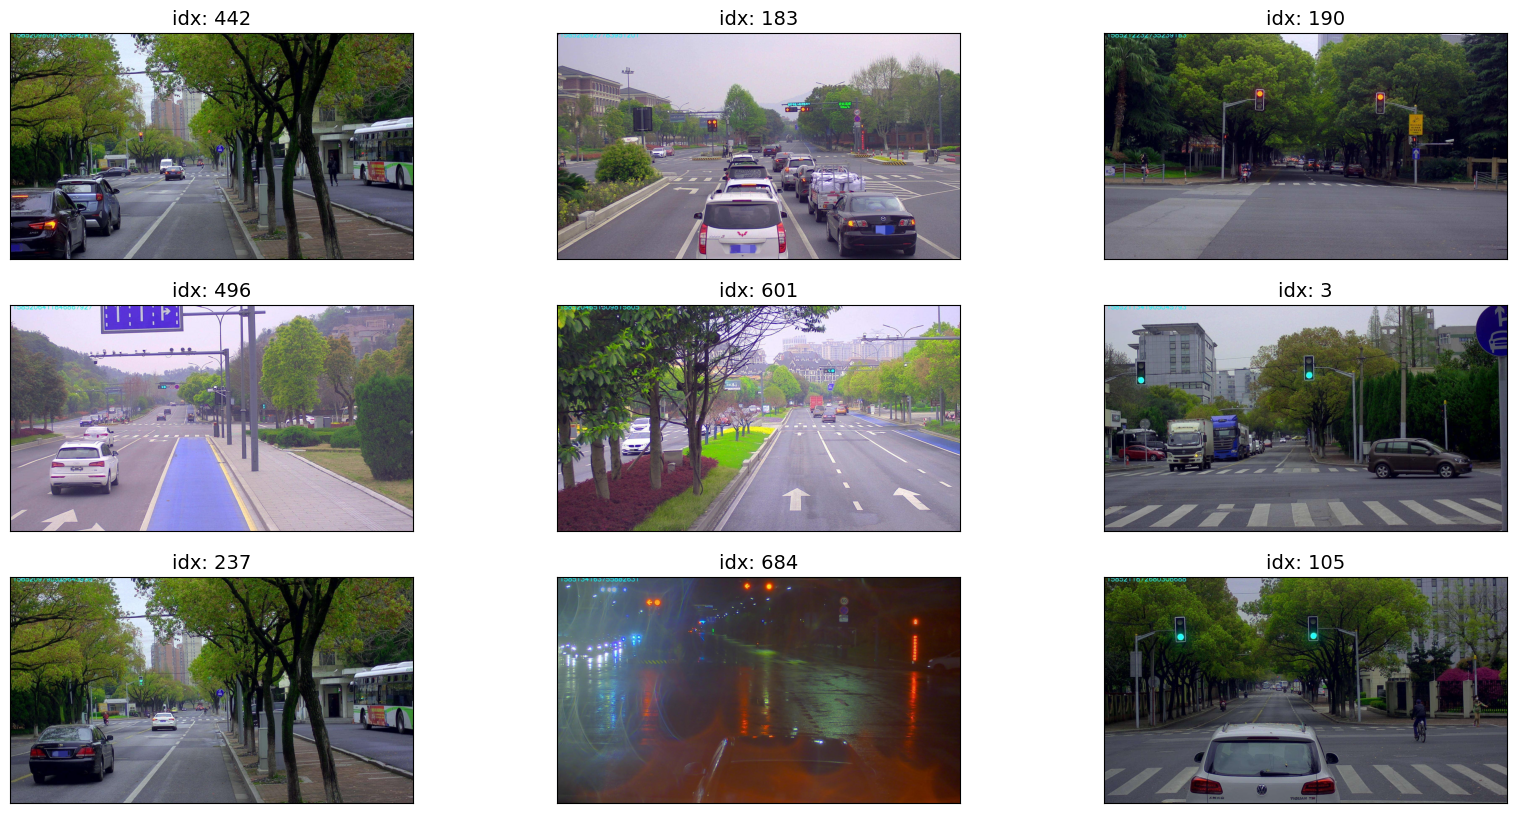

<Figure size 640x480 with 0 Axes>

In [ ]:
from deepml.visualize import show_images_from_dataframe

show_images_from_dataframe(train_df, "./train/images", samples=9, cols=3,
                           figsize=(20, 10), image_file_name_column="image_filename")

The bounding box annotation format is:

$\mathbf{[x_{center},\ y_{center},\ width,\ height]}$, where all the coordinates are normalized in the range: `[0,1]`


Let's store the list bounding boxes associated with each input image in the dataframe.

In [ ]:
def read_bboxes(label_filepath: str):
    with open(label_filepath, "rt") as fp:
        return [list(map(float, line.split())) for line in fp.read().splitlines()]
    
train_df['bboxes'] = [read_bboxes(f"./train/labels/{label_filename}")
                      for label_filename in train_df["label_filename"]]

val_df['bboxes'] = [read_bboxes(f"./valid/labels/{label_filename}")
                      for label_filename in val_df["label_filename"]]

We can convert this bbox coordinates into absolute image coordinates using following equations:

$$
\begin{align}

x_{center} = x_{center-norm} * image_{width} \\

y_{center} = y_{center-norm} * image_{height} \\

bbox_{width} = bbox_{width-norm} * image_{width} \\

bbox_{height} = bbox_{height-norm} * image_{height}  \\

x_{min} = x_{center}  - bbox_{width}  / 2 \\

y_{min} = y_{center}  - bbox_{height} / 2 \\

\end{align}
$$

#### Additional Equations:

You can obtain normalized coordinates [0,1] for given absolute image coordiates of a bouding box:

$$
\begin{align}
 x_{center-norm}  &= \frac{1}{image_{width}}\cdot\left(x_{min} + \frac{1}{2}\cdot box_{width}\right) \\
 y_{center-norm}  &= \frac{1}{image_{height}}\cdot\left(y_{min} + \frac{1}{2}\cdot box_{height}\right) \\
 box_{width-norm} &= \frac{1}{image_{width}} \cdot box_{width} \\
 box_{height-norm} &= \frac{1}{image_{height}} \cdot box_{height} \\
\end{align}
$$


We will need normalized bbox coordinates for model training and absolute image coordinates of boudning boxes for visualization. 

Hence, let's create a separate column for unormalized bbox coordinates by applying above equations

In [ ]:
def unnormalized_bbox_coordinates(bbox: tuple[int, float, float, float, float],
                                actual_image_height: int = 1080,
                                actual_image_width: int = 1920):
    """
    bbox: tuple of normalized bbox coordiates [class_id, x_center, y_center, box_width, box_height]
    return: tuple of unnormalized absolute image bbox coordinates [class_id, x_min, y_min, box_width, box_height]
    """

    class_id, x_center, y_center, bbox_width, bbox_height = bbox
    x_center *= actual_image_width
    y_center *= actual_image_height
    bbox_width *= actual_image_width
    bbox_height *= actual_image_height

    x_min = x_center - (bbox_width / 2)
    y_min = y_center - (bbox_height / 2)

    return int(class_id), x_min, y_min, bbox_width, bbox_height

train_df['abs_bboxes'] = train_df['bboxes'].map(lambda bboxes: [unnormalized_bbox_coordinates(bbox) for bbox in bboxes])
val_df['abs_bboxes'] = val_df['bboxes'].map(lambda bboxes: [unnormalized_bbox_coordinates(bbox) for bbox in bboxes])
train_df.head()

image_filename  \
0  2020-04-04-11_16_56_175331476_jpg.rf.145271b01...   
1  2020-04-04-11_28_33_669437677_jpg.rf.8fef826e0...   
2  2020-04-04-11_31_40_365248546_jpg.rf.e9d4aea32...   
3  2020-03-30-11_51_39_033377846_jpg.rf.aaa04f5f8...   
4  2020-03-30-11_51_38_646675592_jpg.rf.877a70a75...   

                                      label_filename  \
0  2020-04-04-11_16_56_175331476_jpg.rf.145271b01...   
1  2020-04-04-11_28_33_669437677_jpg.rf.8fef826e0...   
2  2020-04-04-11_31_40_365248546_jpg.rf.e9d4aea32...   
3  2020-03-30-11_51_39_033377846_jpg.rf.aaa04f5f8...   
4  2020-03-30-11_51_38_646675592_jpg.rf.877a70a75...   

                                              bboxes  \
0  [[2.0, 0.47552083333333334, 0.2101851851851852...   
1  [[0.0, 0.37734375, 0.36527777777777776, 0.0234...   
2  [[3.0, 0.5299479166666666, 0.36944444444444446...   
3  [[0.0, 0.09244791666666667, 0.3032407407407407...   
4  [[2.0, 0.09375, 0.29305555555555557, 0.021875,...   

                                          abs_bboxes  
0                    [(2, 868.0, 213.0, 90.0, 28.0)]  
1                    [(0, 702.0, 388.0, 45.0, 13.0)]  
2  [(3, 990.9999999999999, 395.0, 53.0, 8.0), (2,...  
3  [(0, 156.0, 271.0, 43.0, 113.0), (0, 952.0, 24...  
4  [(2, 159.0, 261.0, 42.0, 111.0), (2, 955.00000...

**NOTE:** Please feel free to run the below cell multiple times to have a look at random images from the dataset. This will give you an idea of the kind of data we'll be dealing with in this fine-tuning experiment.

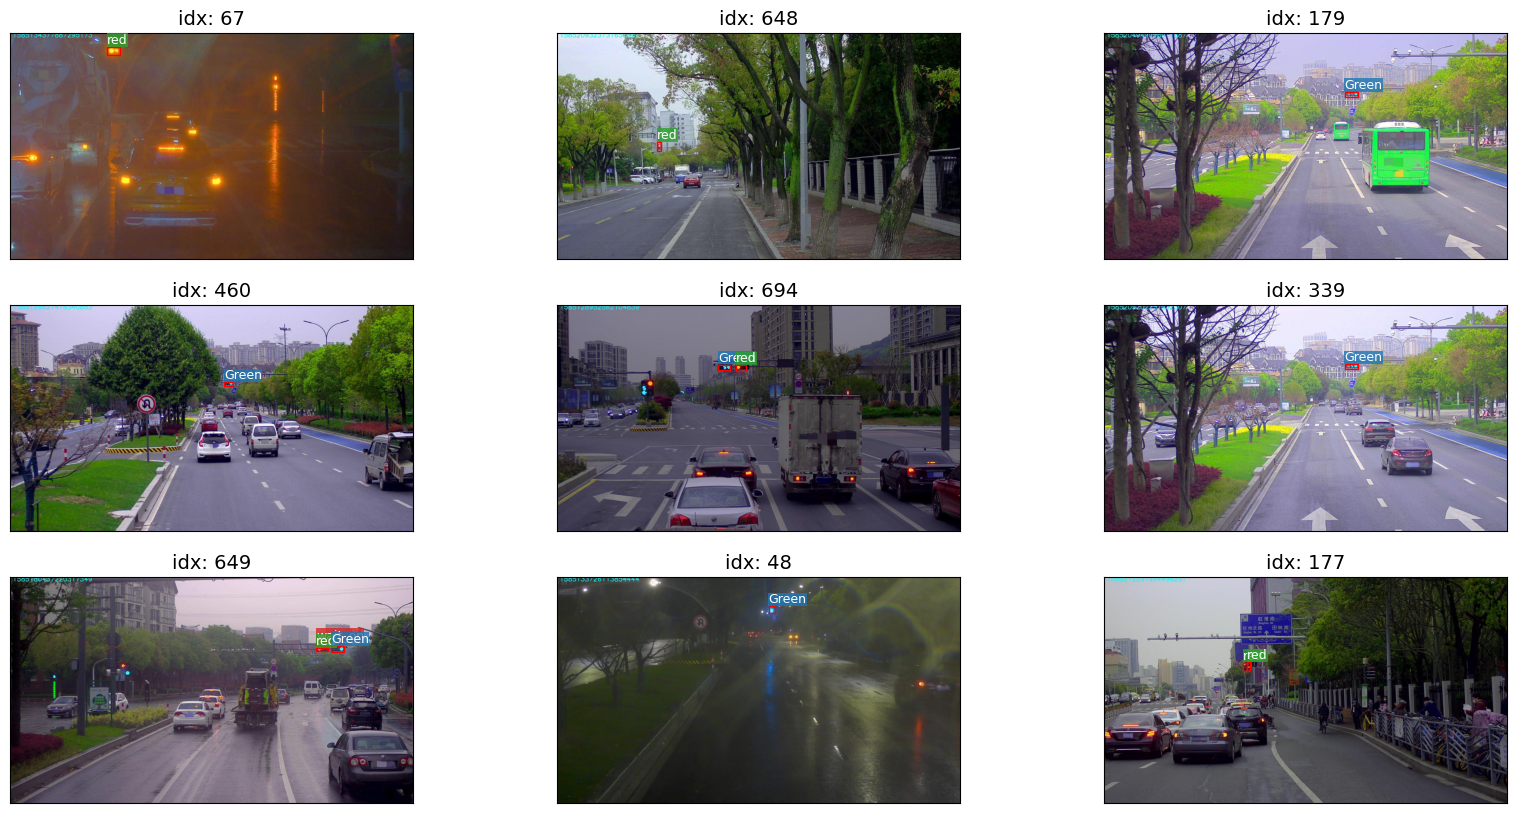

<Figure size 640x480 with 0 Axes>

In [ ]:
show_images_from_dataframe(train_df, "./train/images", samples=9, cols=3,
                           figsize=(20, 10), image_file_name_column="image_filename",
                           bbox_label_column="abs_bboxes", classes=classes)

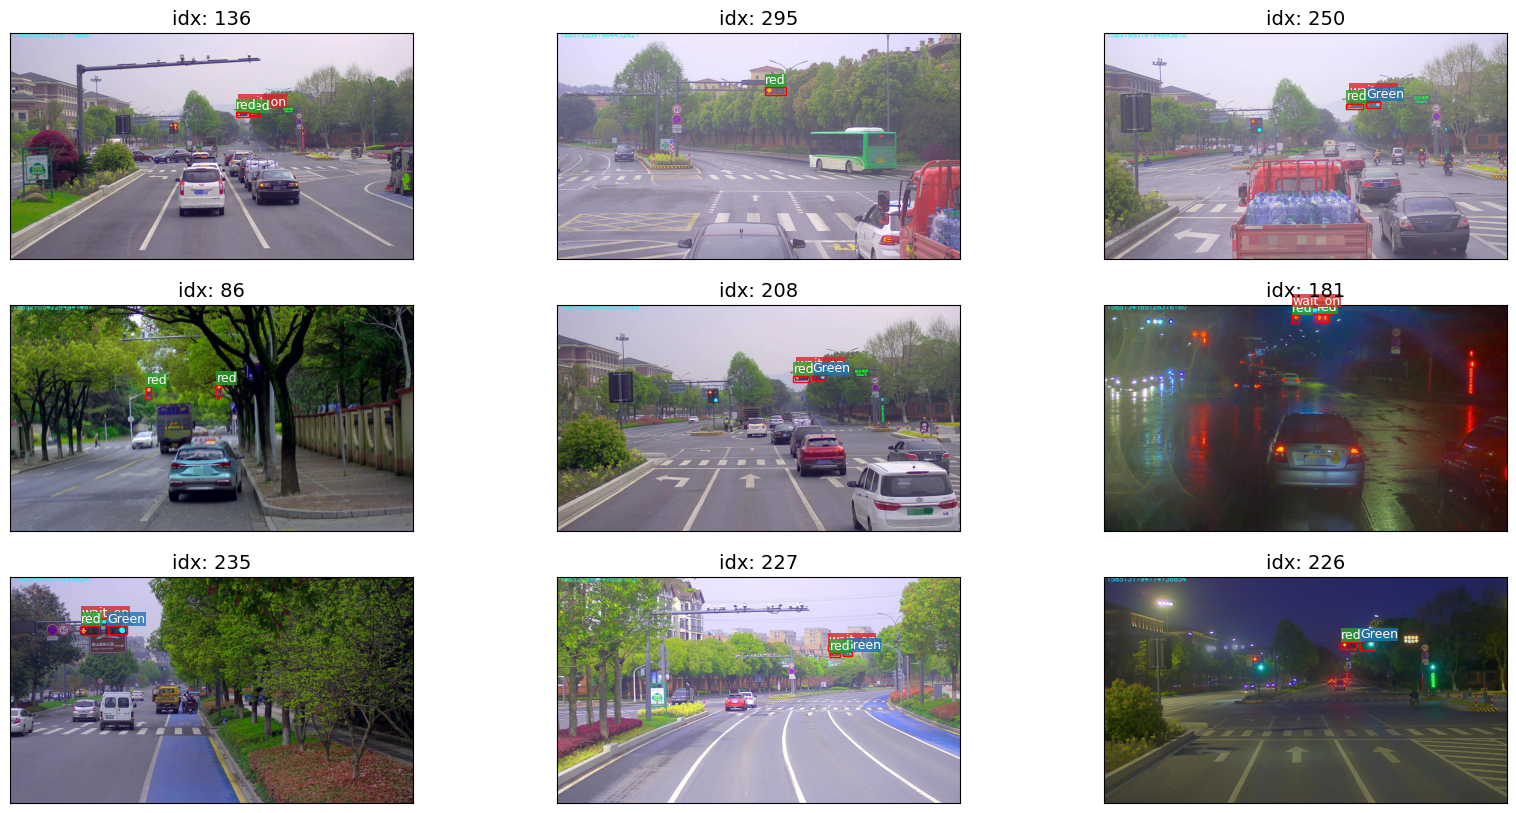

<Figure size 640x480 with 0 Axes>

In [ ]:
show_images_from_dataframe(val_df, "./valid/images", samples=9, cols=3,
                           figsize=(20, 10), image_file_name_column="image_filename",
                           bbox_label_column="abs_bboxes", classes=classes)

# Tile/Patch Generation

Although **RT-DETR** is designed to leverage global context, experiments show that training directly on full-resolution traffic scene images (1920×1080) does not yield satisfactory detection performance, particularly for small traffic lights. This behavior is mainly attributed to the extreme scale imbalance between the background and the target objects.

In [ ]:
"""
Create tiles from high resolution images for YOLO text type labels.
"""
def create_subdirectories(base_dir, dirs):
    new_dirs = {}
    for dir in dirs:
        # Create a subdirectory path that mirrors the original structure
        sub_dir_path = os.path.join(base_dir, dir)
        os.makedirs(sub_dir_path, exist_ok=True)
        new_dirs[dir] = sub_dir_path
    return new_dirs


def adjust_labels_for_tile(labels, dx, dy, tile_width, tile_height, image_width, image_height, tile):
    adjusted_labels = []
    for label in labels:
        label = label.strip()  # Strip whitespace from the label string
        class_id, x_center, y_center, width, height = map(float, label.split())

        # Convert from relative to absolute coordinates in the original image
        abs_x_center = x_center * image_width
        abs_y_center = y_center * image_height
        abs_width = width * image_width
        abs_height = height * image_height

        # Calculate the top-left and bottom-right corners of the bounding box
        abs_x_min = abs_x_center - abs_width / 2
        abs_y_min = abs_y_center - abs_height / 2
        abs_x_max = abs_x_center + abs_width / 2
        abs_y_max = abs_y_center + abs_height / 2

        # Adjust coordinates for the tile
        abs_x_min -= dx
        abs_y_min -= dy
        abs_x_max -= dx
        abs_y_max -= dy

        # Check if the object's bounding box is within the tile
        if (abs_x_min < tile_width and abs_x_max > 0) and (abs_y_min < tile_height and abs_y_max > 0):
            # Clip the coordinates to be within the tile
            clipped_x_min = max(abs_x_min, 0)
            clipped_y_min = max(abs_y_min, 0)
            clipped_x_max = min(abs_x_max, tile_width)
            clipped_y_max = min(abs_y_max, tile_height)

            # Convert back to relative coordinates in the context of the tile
            tile_x_center = ((clipped_x_min + clipped_x_max) / 2) / tile_width
            tile_y_center = ((clipped_y_min + clipped_y_max) / 2) / tile_height
            tile_width_norm = (clipped_x_max - clipped_x_min) / tile_width
            tile_height_norm = (clipped_y_max - clipped_y_min) / tile_height

            adjusted_labels.append(f"{class_id} {tile_x_center} {tile_y_center} {tile_width_norm} {tile_height_norm}")

    return adjusted_labels



def crop_and_label(image_dirs, label_dirs, tile_size=(960, 960), overlap=0.2):
    base_dir = "tiled_data"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # Create subdirectories for images and labels
    new_image_dirs = create_subdirectories(base_dir, image_dirs)
    new_label_dirs = create_subdirectories(base_dir, label_dirs)

    for image_dir, label_dir in zip(image_dirs, label_dirs):
        image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
        for filename in tqdm(image_files, desc=f"Processing {image_dir}"):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + '.txt')

            image = cv2.imread(image_path)
            image_height, image_width = image.shape[:2]

            tile_width, tile_height = tile_size
            step_x = int(tile_width * (1 - overlap))
            step_y = int(tile_height * (1 - overlap))

            for i in range(0, image_width, step_x):
                for j in range(0, image_height, step_y):
                    tile = image[j:min(j + tile_height, image_height), i:min(i + tile_width, image_width)]
                    if tile.shape[0] != tile_height or tile.shape[1] != tile_width:
                        continue

                    adjusted_labels = []
                    if label_path and os.path.exists(label_path):
                        with open(label_path, 'r') as file:
                            labels = file.readlines()
                            adjusted_labels = adjust_labels_for_tile(labels, i, j, tile_width, tile_height, image_width, image_height, tile)

                    new_image_path = os.path.join(new_image_dirs[image_dir], f"{os.path.splitext(os.path.basename(image_path))[0]}_{i}_{j}.jpg")
                    new_label_path = os.path.join(new_label_dirs[label_dir], f"{os.path.splitext(os.path.basename(label_path))[0]}_{i}_{j}.txt")

                    cv2.imwrite(new_image_path, tile)
                    with open(new_label_path, 'w') as file:
                        file.write('\n'.join(adjusted_labels))


In [ ]:
TILE_WIDTH = 1024
TILE_HEIGHT = 1024
TILE_OVERLAP = 0.1

image_dirs = [
    "./train/images",
    "./valid/images",
]
label_dirs = [
    "./train/labels",
    "./valid/labels",
]


crop_and_label(image_dirs, label_dirs, tile_size=(TILE_WIDTH, TILE_HEIGHT), overlap=TILE_OVERLAP)

Processing ./valid/images: 100%|██████████| 367/367 [00:08<00:00, 41.53it/s]


In [ ]:
train_images = os.listdir("./tiled_data/train/images")
val_images = os.listdir("./tiled_data/valid/images")

train_df = pd.DataFrame({"image_filename": train_images})
train_df["label_filename"] = [image_filename.replace(".jpg", ".txt") for image_filename in train_images]

val_df = pd.DataFrame({"image_filename": val_images})
val_df["label_filename"] = [image_filename.replace(".jpg", ".txt") for image_filename in val_images]

print("Number of Training Images:", train_df.shape[0])
print("Number of Validation Images:", val_df.shape[0])


train_df['bboxes'] = [read_bboxes(f"./tiled_data/train/labels/{label_filename}")
                      for label_filename in train_df["label_filename"]]

val_df['bboxes'] = [read_bboxes(f"./tiled_data/valid/labels/{label_filename}")
                      for label_filename in val_df["label_filename"]]

# for visualziation
train_df['abs_bboxes'] = train_df['bboxes'].map(lambda bboxes: [unnormalied_bbox_coordinates(bbox, TILE_WIDTH, TILE_HEIGHT) for bbox in bboxes])
val_df['abs_bboxes'] = val_df['bboxes'].map(lambda bboxes: [unnormalied_bbox_coordinates(bbox, TILE_WIDTH, TILE_HEIGHT) for bbox in bboxes])
train_df.head()

Number of Training Images: 855
Number of Validation Images: 367


image_filename  \
0  2020-03-30-11_53_34_584016915_jpg.rf.1e9744b2a...   
1  2020-03-30-11_46_14_679477606_jpg.rf.25abba4db...   
2  2020-04-04-11_08_34_422156015_jpg.rf.12ace8706...   
3  2020-04-04-11_18_21_441563806_jpg.rf.b7da7570c...   
4  2020-03-30-11_46_56_570511810_jpg.rf.84aec1012...   

                                      label_filename  \
0  2020-03-30-11_53_34_584016915_jpg.rf.1e9744b2a...   
1  2020-03-30-11_46_14_679477606_jpg.rf.25abba4db...   
2  2020-04-04-11_08_34_422156015_jpg.rf.12ace8706...   
3  2020-04-04-11_18_21_441563806_jpg.rf.b7da7570c...   
4  2020-03-30-11_46_56_570511810_jpg.rf.84aec1012...   

                                              bboxes  \
0  [[2.0, 0.72412109375, 0.3134765625, 0.03417968...   
1  [[2.0, 0.90087890625, 0.4130859375, 0.02246093...   
2  [[0.0, 0.97705078125, 0.1943359375, 0.03417968...   
3                                                 []   
4  [[2.0, 0.04345703125, 0.26220703125, 0.0498046...   

                                          abs_bboxes  
0                    [(2, 724.0, 272.0, 35.0, 98.0)]  
1  [(2, 911.0, 393.0, 23.0, 60.0), (2, 479.000000...  
2                    [(0, 983.0, 182.0, 35.0, 34.0)]  
3                                                 []  
4  [(2, 19.0, 204.0, 51.0, 129.0), (2, 918.0, 173...

In [ ]:
show_images_from_dataframe(train_df, "./tiled_data/train/images", samples=9, cols=3,
                           figsize=(20, 20), image_file_name_column="image_filename",
                           bbox_label_column="abs_bboxes", classes=classes)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images_from_dataframe(val_df, "./tiled_data/valid/images", samples=9, cols=3,
                           figsize=(20, 20), image_file_name_column="image_filename",
                           bbox_label_column="abs_bboxes", classes=classes)

Output hidden; open in https://colab.research.google.com to view.

<h2 style = "color: green;">2. Train the Model </h2>

#### Create YAML Config

In [ ]:
cwd = os.getcwd()

class_index_dict = {0:'Green', 1:'off', 2:'red', 3:'wait_on', 4:'yellow'}

data = {
    'path': cwd,
    'train': './tiled_data/train/images',
    'val': './tiled_data/valid/images',
    'test': None,
    'names': class_index_dict
}

file_path = 'traffic_light_detection.yaml'

with open(file_path, 'w') as file:
    yaml.dump(data, file)

# Load RT-DETR Model

In [ ]:
model = RTDETR('rtdetr-l.pt')

In [ ]:
NUM_EPOCHS = 60
TRAIN_IMG_SIZE = TILE_HEIGHT
BATCH_SIZE = 0.80 #80% GPU memory utilization, so batch size is derived automatically
cosine_lr = True #Utilizes a cosine learning rate scheduler, adjusting the learning rate following a cosine curve over epochs. Helps in managing learning rate for better convergence.
lr0 = 0.01 # initial learning rate
lrf = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf)

model.train(
    data='traffic_light_detection.yaml',
    epochs=NUM_EPOCHS,
    imgsz=TRAIN_IMG_SIZE,
    batch=BATCH_SIZE,
    cos_lr=cosine_lr,

)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=traffic_light_detection.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/60      3.83G      1.146      8.204     0.3902          4       1024: 100% ━━━━━━━━━━━━ 428/428 2.3it/s 3:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.2it/s 17.6s
                   all        367        424      0.686      0.225      0.157      0.116

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/60      3.99G     0.8193     0.7093    0.09545          5       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/60      4.05G      0.626     0.7704     0.0841          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.855      0.487      0.487      0.278

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/60      4.19G      0.554     0.9107    0.07256          6       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/60      4.21G     0.5888     0.6095    0.06902          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.833      0.534      0.571      0.329

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/60      4.37G      1.209       0.35      0.132          3       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/60      4.43G     0.5275     0.5225      0.055          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.676      0.629      0.619      0.353

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/60      4.56G     0.2436     0.3427    0.05027          2       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/60      4.62G     0.5281     0.5146    0.05605          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424       0.78      0.619       0.69       0.41

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/60      4.77G     0.6676     0.4713    0.03552          6       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/60       4.8G     0.5156      0.451     0.0467          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.745       0.63      0.703      0.405

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/60      4.95G     0.2848      0.374    0.03283          1       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/60      4.99G     0.4771     0.4597    0.04704          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.754      0.744      0.745      0.422

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/60      5.14G     0.8359     0.3529    0.03903          5       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/60       5.2G     0.5226     0.4485    0.06303          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.7s
                   all        367        424        0.8       0.71      0.714      0.407

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/60      5.34G     0.6205     0.4393    0.04791          5       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/60      5.39G     0.5218     0.4341    0.05774          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.1it/s 15.2s
                   all        367        424      0.865       0.76      0.772      0.435

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/60      5.52G     0.2345      0.329    0.04024          3       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/60      5.58G     0.4771     0.4176    0.04804          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.7s
                   all        367        424      0.815      0.734      0.769      0.401

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/60      5.72G     0.4273     0.4176    0.02513          4       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/60      5.77G     0.4418      0.398    0.04173          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.2s
                   all        367        424      0.864      0.683      0.754      0.432

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/60      5.92G     0.2851     0.3515    0.01464          2       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/60      5.96G     0.4759     0.4222    0.04632          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.627      0.651      0.605      0.329

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/60      6.09G     0.7528     0.4049    0.06114          5       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/60      6.15G     0.5045     0.4434     0.0496          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.774      0.815      0.782      0.412

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/60      6.28G     0.7146     0.4595    0.05701          5       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/60      6.34G       0.47     0.4599    0.04464          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.5s
                   all        367        424      0.775      0.779      0.787      0.423

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/60      6.49G      0.726     0.4375    0.04385          6       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/60      6.52G     0.4878     0.4488    0.04609          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.756      0.766      0.756      0.432

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/60      6.67G      1.133     0.3647    0.07098          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/60      6.71G     0.4508      0.425    0.04418          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.829      0.797      0.826      0.465

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/60      6.86G     0.2365      0.675    0.05894          3       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/60       6.9G     0.4346     0.4161    0.04175          6       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.861      0.762      0.821       0.48

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/60      7.06G     0.5681     0.4205    0.06065          4       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/60      7.09G     0.4344     0.4013    0.04153          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.849      0.861      0.865      0.501

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/60      7.15G          0       0.33          0          0       1024: 0% ──────────── 0/428  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/60      7.26G     0.4493     0.4087    0.04116          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.742      0.786      0.774      0.457

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/60      7.43G     0.6458     0.7456    0.04806          5       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/60      7.48G     0.4668      0.411    0.04266          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.2s
                   all        367        424      0.777      0.783      0.798      0.454

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/60       4.6G      1.012     0.8215    0.08617          2       1024: 0% ──────────── 0/428  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/60       4.6G     0.4732     0.4424    0.04885          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.803      0.754      0.768      0.441

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/60       4.6G     0.6009     0.3945    0.09974          3       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/60      4.62G     0.4506     0.4203    0.04371          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.828      0.844      0.824      0.472

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/60       4.7G     0.2434     0.3598    0.01641          3       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/60      4.73G     0.4465     0.4153    0.04411          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.884      0.848      0.852      0.499

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/60      4.81G     0.5435     0.4691    0.05952          2       1024: 0% ──────────── 0/428  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/60      4.82G     0.4389     0.3987    0.04043          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.863      0.866      0.859      0.484

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/60       4.9G      1.126     0.3462    0.05062          4       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/60      4.94G     0.4269     0.3771     0.0389          5       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.866      0.848      0.832       0.47

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/60      4.99G     0.3685     0.3852    0.01417          3       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/60      5.03G     0.4376     0.4115     0.0399          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.827      0.805      0.813      0.447

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/60      5.15G      1.218     0.2813     0.2538          1       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/60      5.18G     0.4259     0.3861    0.04046          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.891      0.883      0.887      0.504

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/60      5.35G     0.4499     0.3544    0.02267          3       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/60      5.38G     0.4201     0.3814    0.03852          3       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424       0.82       0.87      0.851      0.499

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/60      5.52G     0.1068     0.2269    0.01469          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/60      5.57G     0.4055     0.3663    0.03774          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.835      0.881      0.875      0.529

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/60      5.71G      0.355      0.419    0.01558          4       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      30/60      5.76G     0.4455      0.354    0.04281          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.867      0.876      0.875      0.502

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/60      5.91G     0.4406     0.3603    0.04073          6       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      31/60      5.94G       0.41     0.3614    0.03803          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.905      0.836      0.857      0.477

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/60         6G          0   0.006074          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/60      6.14G     0.4039     0.3602     0.0392          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.863      0.858      0.856      0.506

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/60      6.29G     0.6847     0.4441    0.09918          1       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/60      6.32G     0.4285     0.3606    0.03992          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.911       0.85      0.866       0.51

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/60      6.49G     0.3995     0.3715    0.04192          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      34/60      6.52G     0.4034     0.3581    0.03757          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.899      0.883      0.899      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/60      6.57G          0   0.009251          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/60      6.71G     0.4044     0.3575    0.03664          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.924      0.892       0.92      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/60      6.86G     0.2882     0.3207    0.02661          2       1024: 0% ──────────── 0/428  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/60       6.9G      0.383     0.3488    0.03311          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.924      0.914      0.905      0.512

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/60      7.06G     0.3318     0.3312    0.03913          4       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/60       7.1G      0.396     0.3404    0.03507          4       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.7s
                   all        367        424      0.913      0.907      0.912      0.534

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/60      7.24G     0.4636     0.4182    0.06379          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      38/60      7.28G     0.3868     0.3268    0.03522          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.913      0.908      0.921      0.539

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/60      7.45G      0.215     0.3112    0.01095          3       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      39/60      7.48G     0.3881     0.3552    0.03513          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.909      0.896        0.9      0.523

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/60      4.69G     0.6893     0.3736    0.03323          6       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/60      4.69G     0.3852     0.3485    0.03297          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.913      0.879      0.902      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/60      4.69G      1.981    0.00424     0.3506          1       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/60      4.69G     0.4149     0.3518    0.03772          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.875      0.899      0.869      0.485

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/60      4.73G     0.5799     0.4162    0.04167          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      42/60      4.76G     0.4089     0.3509    0.03813          5       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.888      0.908      0.893      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/60      4.76G          0   0.006978          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/60      4.87G     0.3899      0.347    0.03459          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424       0.91      0.903      0.911      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/60      4.92G     0.1149     0.2176    0.02471          2       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/60      4.96G     0.3546     0.3277    0.03058          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.907      0.893      0.877       0.52

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/60      5.04G     0.2751     0.3353    0.01998          3       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/60      5.06G      0.362     0.3328     0.0333          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424       0.89      0.887      0.878      0.518

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/60      5.16G     0.3296     0.3192    0.02626          2       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      46/60      5.18G     0.3668     0.3368    0.03406          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.3s
                   all        367        424      0.903      0.907      0.915       0.53

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/60      5.24G          0     0.3531          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      47/60      5.38G     0.3761     0.3194    0.03672          3       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.904      0.906      0.907      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/60      5.43G          0   0.002119          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/60      5.57G     0.3615      0.329    0.03086          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.8it/s 15.8s
                   all        367        424      0.907      0.897      0.895      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/60      5.62G          0   0.002596          0          0       1024: 0% ──────────── 0/428  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/60      5.76G     0.3423     0.3254    0.03006          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.914      0.893      0.913      0.541

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/60      5.91G     0.4335     0.4224    0.04453          5       1024: 0% ──────────── 0/428  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      50/60      5.95G     0.3608     0.3244    0.03387          3       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:51
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.917      0.933      0.928      0.542
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      51/60      6.11G     0.2371     0.3305    0.01037          1       1024: 0% ──────────── 0/428  1.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      51/60      6.14G      0.323     0.3039    0.02937          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.917      0.932      0.927       0.54

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      52/60       6.3G     0.8077     0.3232    0.07355          2       1024: 0% ──────────── 0/428  0.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      52/60      6.34G      0.317     0.2973    0.02926          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.8it/s 15.8s
                   all        367        424      0.917      0.931      0.926      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      53/60      6.48G      0.346     0.3501    0.04531          3       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      53/60      6.53G     0.3284     0.3092    0.02956          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.923      0.929      0.926      0.537

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      54/60      6.69G    0.05037     0.1416   0.006048          1       1024: 0% ──────────── 0/428  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      54/60      6.71G     0.3086     0.2926    0.02808          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.907      0.928      0.919      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      55/60      6.88G     0.5318      0.422    0.04865          3       1024: 0% ──────────── 0/428  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      55/60       6.9G     0.3211     0.2995    0.03086          1       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.6s
                   all        367        424      0.921      0.926      0.927      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      56/60      7.07G      0.123     0.2691    0.01418          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      56/60       7.1G     0.3106     0.2935    0.02772          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.916      0.904      0.892      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      57/60      7.25G     0.2339     0.3178    0.01353          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      57/60      7.28G     0.3327     0.2996    0.03036          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.4it/s 2:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.912      0.914      0.903      0.535

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      58/60      7.45G     0.2743     0.3431    0.01276          2       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      58/60      7.47G     0.3162     0.2937    0.02957          2       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.5s
                   all        367        424      0.901      0.911      0.898      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      59/60      4.67G     0.4846     0.4188    0.06568          1       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      59/60      4.67G      0.295      0.281    0.02634          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 5.9it/s 15.5s
                   all        367        424      0.902      0.912      0.903      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      60/60      4.67G          0   0.004044          0          0       1024: 0% ──────────── 0/428  0.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      60/60      4.67G     0.3073      0.286    0.02806          0       1024: 100% ━━━━━━━━━━━━ 428/428 2.5it/s 2:54
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.0it/s 15.4s
                   all        367        424      0.906      0.911      0.903      0.537

60 epochs completed in 3.431 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 66.4MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 66.4MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 310 layers, 31,994,015 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 6.4it/s 14.4s
                   all        367        424      0.921      0.926      0.926      0.548
                 Green        112       

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d63db30b4a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
!ls runs/detect/train

args.yaml			 results.csv	       val_batch0_labels.jpg
BoxF1_curve.png			 results.png	       val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg      val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg      val_batch1_pred.jpg
BoxR_curve.png			 train_batch21400.jpg  val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch21401.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch21402.jpg  weights
labels.jpg			 train_batch2.jpg


(np.float64(-0.5), np.float64(2399.5), np.float64(1199.5), np.float64(-0.5))

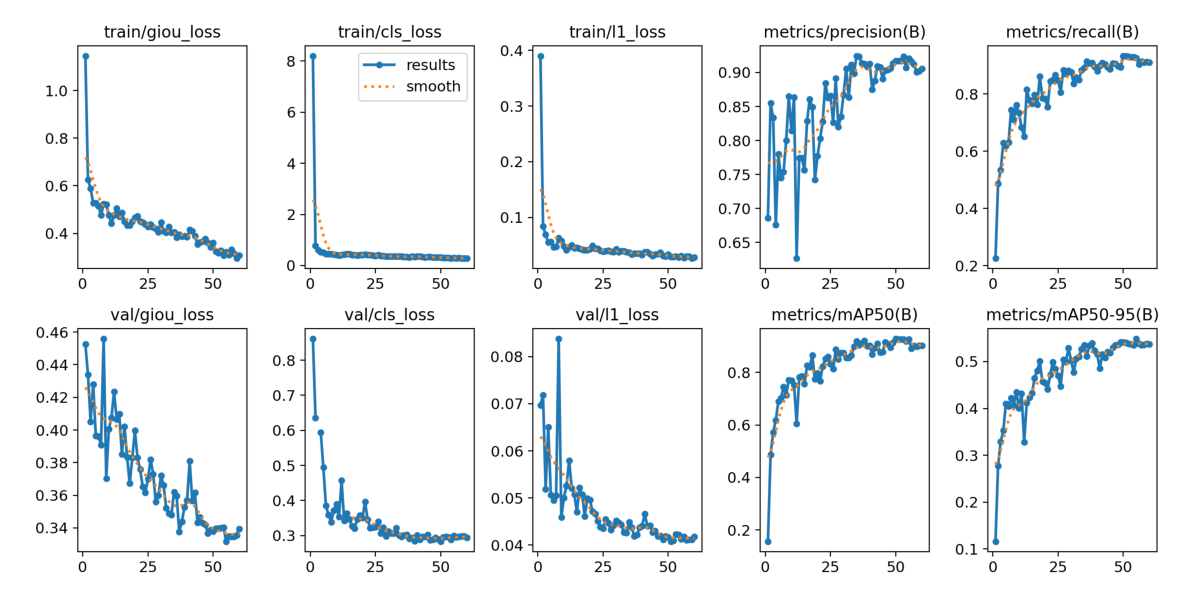

In [ ]:
results_img = plt.imread('runs/detect/train/results.png')
plt.figure(figsize=(15, 12))
plt.imshow(results_img)
plt.axis('off')

### Visualize the model prediction on Sample Tiled Images

Feel free to change the index value to verify model's prediction


image 1/1 /content/tiled_data/valid/images/2020-03-30-11_44_50_514842423_jpg.rf.33c66ca03acd4d113ff145468b9af1a5_0_0.jpg: 1024x1024 2 Greens, 124.8ms
Speed: 3.6ms preprocess, 124.8ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/detect/predict2


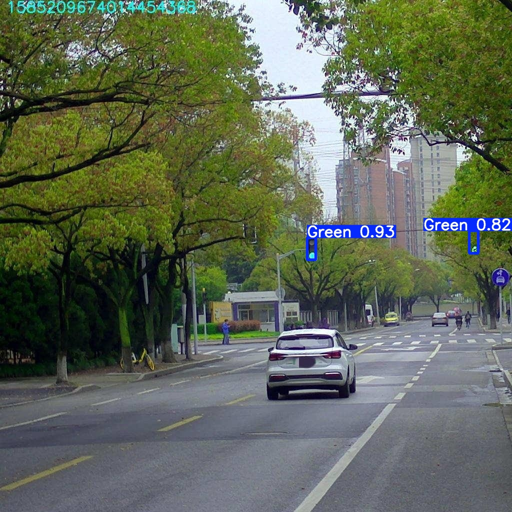

In [ ]:
index = 4
img_dir = "./tiled_data/valid/images"
image_path = f"{img_dir}/{val_df.loc[index, 'image_filename']}"
result = model.predict(image_path, save=True)
Image.open(f"{result[0].save_dir}/{os.path.split(result[0].path)[1]}").resize((512, 512))

#### Model Inference on Actual Image Size (1920 x 1080) without SAHI

Here, trained Model's inference is directly performed 1920x1080, however the input image is internally resized by the predict function into the image resolution (Here, 1024x1024) on which model is trained on.


image 1/1 /content/valid/images/2020-04-04-11_18_10_638711632_jpg.rf.251cc63ad4437077cca9061457022ef1.jpg: 1024x1024 2 reds, 1 wait_on, 155.4ms
Speed: 20.0ms preprocess, 155.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/detect/predict2


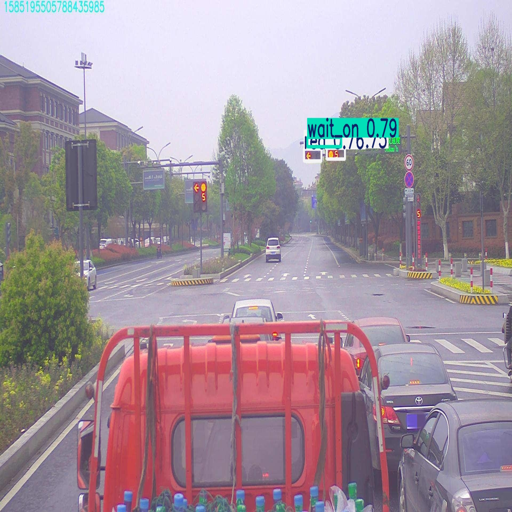

In [ ]:
index = 19
img_dir = "./valid/images"
image_list = os.listdir(img_dir)
image_path = f"{img_dir}/{image_list[index]}"
result = model.predict(image_path, save=True)
Image.open(f"{result[0].save_dir}/{os.path.split(result[0].path)[1]}").resize((512, 512))

## SAHI Inference

In [ ]:
!pip install sahi

In the following section, we run the model's inference on sliced images using **SAHI**

In [ ]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

detection_model = AutoDetectionModel.from_pretrained(
    model_type='ultralytics',
    model_path="runs/detect/train/weights/best.pt",
    confidence_threshold=0.5,
    device="cuda"
)

Performing prediction on 15 slices.


In [ ]:
result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=1024,
        slice_width=1024,
        overlap_height_ratio=0.1,
        overlap_width_ratio=0.1
    )

Performing prediction on 4 slices.


In [ ]:
from sahi.predict import visualize_object_predictions

v = visualize_object_predictions(
    np.array(Image.open(image_path)),
    object_prediction_list=result.object_prediction_list,
)
Image.fromarray(v['image'])

Output hidden; open in https://colab.research.google.com to view.

<h2 style = "color: green;">3. Validate the Model </h2>

Load the best val model weights.

In [ ]:
# Load model.
model = RTDETR('runs/detect/train/weights/best.pt')


In [ ]:
results = model.val(plots=True)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 310 layers, 31,994,015 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2246.4±755.9 MB/s, size: 225.6 KB)
val: Scanning /content/tiled_data/valid/labels.cache... 367 images, 117 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 367/367 28.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 1.4s/it 31.3s
                   all        367        424      0.925      0.923      0.926      0.542
                 Green        112        153      0.929      0.935      0.921      0.658
                   red        166        229       0.93      0.935      0.945      0.618
               wait_on         29         29      0.921      0.931      0.931      0.408
                yellow         11         13       0.92      0.892      0.907      0.483
Speed: 4.7ms preprocess, 75.6ms inference,

In [ ]:
results.box.map  # map50-95

np.float64(0.5416823057147397)

We achieved 54.2 mAP50-95 on the validation set.

#### Classwise Model Performance Metrics:

In [ ]:
results.to_df()

shape: (4, 8)
┌─────────┬────────┬───────────┬─────────┬─────────┬─────────┬─────────┬──────────┐
│ Class   ┆ Images ┆ Instances ┆ Box-P   ┆ Box-R   ┆ Box-F1  ┆ mAP50   ┆ mAP50-95 │
│ ---     ┆ ---    ┆ ---       ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---      │
│ str     ┆ i64    ┆ i64       ┆ f64     ┆ f64     ┆ f64     ┆ f64     ┆ f64      │
╞═════════╪════════╪═══════════╪═════════╪═════════╪═════════╪═════════╪══════════╡
│ Green   ┆ 112    ┆ 153       ┆ 0.92865 ┆ 0.93464 ┆ 0.93164 ┆ 0.92097 ┆ 0.65752  │
│ red     ┆ 166    ┆ 229       ┆ 0.93048 ┆ 0.93516 ┆ 0.93281 ┆ 0.94463 ┆ 0.61842  │
│ wait_on ┆ 29     ┆ 29        ┆ 0.92059 ┆ 0.93103 ┆ 0.92578 ┆ 0.93118 ┆ 0.4078   │
│ yellow  ┆ 11     ┆ 13        ┆ 0.92046 ┆ 0.89162 ┆ 0.90581 ┆ 0.90734 ┆ 0.483    │
└─────────┴────────┴───────────┴─────────┴─────────┴─────────┴─────────┴──────────┘

<h2 style = "color: green;">4. Inference on given video</h2>

<h3 style><a href = "https://www.dropbox.com/scl/fi/v3uwaid41m5jypk8mhplr/inference_traffic_light_video.mp4?rlkey=u4l9kxa0av81qxcfod06z7e0g&st=ab83a04b&dl=1">Inference Video</a></h3>


<video
     controls
     src="https://www.dropbox.com/scl/fi/v3uwaid41m5jypk8mhplr/inference_traffic_light_video.mp4?rlkey=u4l9kxa0av81qxcfod06z7e0g&st=kp0dxjz3&dl=1"
     width="640">
 </video>

In [ ]:
import urllib.request

inference_video_url = "https://www.dropbox.com/scl/fi/v3uwaid41m5jypk8mhplr/inference_traffic_light_video.mp4?rlkey=u4l9kxa0av81qxcfod06z7e0g&st=kp0dxjz3&dl=1"

urllib.request.urlretrieve(inference_video_url, "road_drive_video.mp4")

('road_drive_video.mp4', <http.client.HTTPMessage at 0x7d63a241b4d0>)

In [ ]:
def run_sahi_inference_on_video(detection_model, video_path: str, output_path: str, slice_width: int = 1024, slice_height: int = 1024, overlap_ratio: float = 0.1):

    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    writer = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc('M','J','P','G'),
        fps,
        (width, height),
    )


    # PROCESS VIDEO
    frame_id = 0

    bar = tqdm(range(total_frames))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_id += 1
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # SAHI sliced prediction
        result = get_sliced_prediction(
            image=frame,
            detection_model=detection_model,
            slice_height=slice_height,
            slice_width=slice_width,
            overlap_height_ratio=overlap_ratio,
            overlap_width_ratio=overlap_ratio,
            verbose=False,
        )

        # Draw predictions
        annotated_frame = visualize_object_predictions(
            image=frame,
            object_prediction_list=result.object_prediction_list,
            rect_th=2,
            text_size=0.6,
            text_th=2,
        )

        annotated_frame = cv2.cvtColor(annotated_frame['image'], cv2.COLOR_RGB2BGR)
        writer.write(annotated_frame)
        bar.update(1)


    # CLEANUP
    bar.close()
    cap.release()
    writer.release()
    print("Video Processed!")


In [ ]:
run_sahi_inference_on_video(detection_model, "./road_drive_video.mp4", "./obj_detection_road_drive_video.avi",
                            1024,
                            1024,
                            overlap_ratio=0.1)

100%|█████████▉| 454/455 [02:54<00:00,  2.60it/s]

Video Processed!


Video Inference Shared Result: https://drive.google.com/file/d/1xT626uDlC7MMKMAdsWNUHZK2A3Rgv58i/view?usp=drive_link